In [1]:
pip install git+https://github.com/albumentations-team/albumentations


  Cloning https://github.com/albumentations-team/albumentations to c:\users\admin\appdata\local\temp\pip-req-build-0n8cacw4
  Resolved https://github.com/albumentations-team/albumentations to commit edb09e36cfe68d159be2167d6b02fb44d995d5a1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations 'C:\Users\Admin\AppData\Local\Temp\pip-req-build-0n8cacw4'


In [2]:
import torch
import torch.nn as nn
import os
import cv2
import albumentations as A
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [3]:
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
import random
import copy

In [4]:
if(os.path.split(os.getcwd())[1] == "plain-augmentation"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

cuda=False

Current Working Directory: progettoVIPM


In [5]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import csv
from enum import Enum
from torchvision import models
import matplotlib.pyplot as plt

class datasets(Enum):
    TRAINING_LABELED = ["train_small.csv", "train_set"]
    TRAINING_UNLABELED = ["train_unlabeled.csv", "train_set"]
    TEST = ["val_info.csv", "val_set"]
    TEST_DEGRADED = ["val_info.csv", "val_set_degraded"]

class networks(Enum):
    ALEXNET = [227, models.alexnet(pretrained=True), "AlexNet"]
    RESNET50 = [224, models.resnet50(pretrained=True), "ResNet50"]
    GOOGLENET = [224, models.googlenet(pretrained=True), "GoogLeNet"]

class ImageDataset(Dataset):
    def visualize_image(image_tensor):
        print(image_tensor)
        
        image_np = np.moveaxis(torch.squeeze(image_tensor).numpy(), 0,-1)

        for i in range(3): # Assuming the last dimension is the channel dimension 
            channel = image_np[..., i] 
            min_val = channel.min() 
            max_val = channel.max() 
            image_np[..., i] = (channel - min_val) / (max_val - min_val) 

        image_np = (image_np * 255).astype('uint8')
        print(image_np)
        plt.figure()
        plt.imshow(image_np)
        print(image_np)
        plt.axis('off') # Hide the axis plt.show()

    def __init__(self, dataset, network_input_size, cuda, transform=None):
        super().__init__()
        self.images_names = []
        self.labels = []
        self.transform = transform
        self.cuda = cuda
        dataset = dataset.value
        annotations_file = dataset[0]
        img_dir = dataset[1]
        with open(annotations_file, newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                self.images_names.append("./{}/{}".format(img_dir, row[0]))
                self.labels.append(row[1])
        self.images_names = np.array(self.images_names)
        self.labels = np.array(self.labels)
        # in base al valore passato si sceglie la rete che utilizzerà il dataset, serve per modificare le dimensioni delle immagini
        self.im_size = network_input_size
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        image_bgr = cv2.resize((cv2.imread(self.images_names[index], cv2.IMREAD_COLOR).astype(np.double)/255), 
                                       (self.im_size,self.im_size), 
                                        interpolation=cv2.INTER_CUBIC).astype(np.float32)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        #moveaxis serve per avere come dimensione dell'immagine (3, righe, colonne) invece di (righe, colonne, 3)
        if self.transform is None:
            image = np.moveaxis(image_rgb, -1, 0)
        else:  #apply the transformation pipe                    
            #print("image_rgb.shape", image_rgb.shape)
            image = self.transform(image=image_rgb)["image"]        
            #print("image.shape", image.shape)
            #image = np.moveaxis(image, -1, 0) non necessario!
        
        label = self.labels[index]
        if(self.cuda):
            return torch.from_numpy(image).cuda(), label
        else:
            return image, label
        



  0%|          | 5/5020 [00:00<01:54, 43.97it/s]


culo torch.Size([3, 128, 128])
culo torch.Size([3, 128, 128])
culo torch.Size([3, 128, 128])
culo torch.Size([3, 256, 256])
culo torch.Size([3, 256, 256])
culo torch.Size([3, 256, 256])


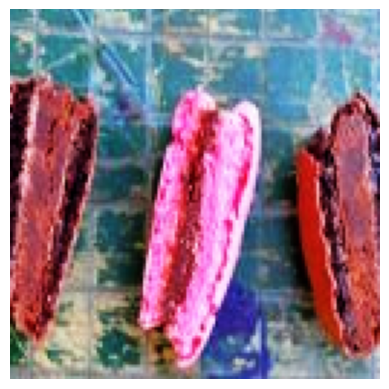

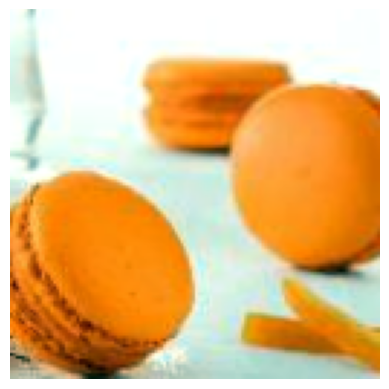

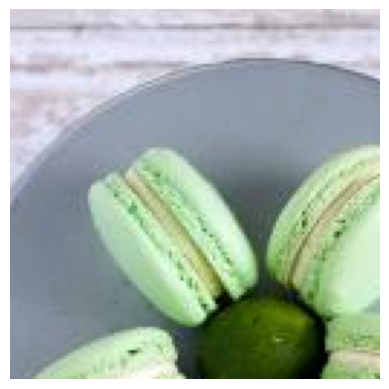

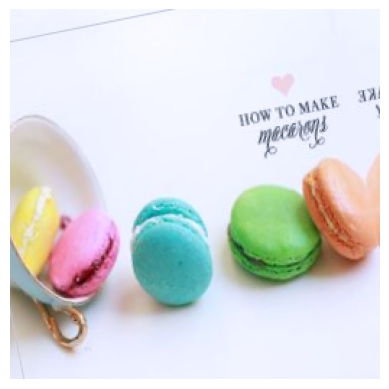

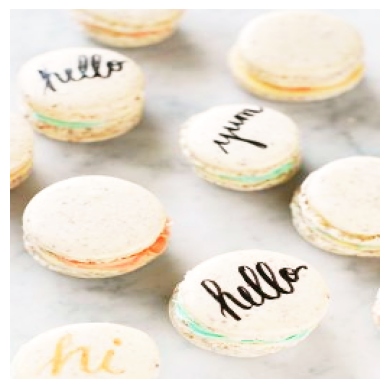

In [6]:
train_transform = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),        
        A.RandomToneCurve(scale=0.7, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
random.seed(42)


from utils.loadersAndEnums import datasets
from utils.loadersAndEnums import networks
from utils.loadersAndEnums import ImageDataset
from utils.visualizing import visualize_some_image_in_loader

datasetholder = ImageDataset(dataset=datasets.TRAINING_LABELED, network_input_size=256, cuda=False, transform=train_transform)
loader = DataLoader(dataset=datasetholder, shuffle=False, batch_size=1)


visualize_some_image_in_loader(loader, 4)


In [7]:
# Convert labels to one-hot encoding
def one_hot_encode(labels, num_classes):
    one_hot_labels = np.zeros((labels.size, num_classes))
    one_hot_labels[np.arange(labels.size), labels] = 1
    return one_hot_labels

#images_y = one_hot_encode(np.array(images_y), 251)